In [184]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
import networkx as nx

In [185]:
df = pd.read_csv('stats.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['item_description'] == 'Botella_750ml']
columns_drop = ['business', 'category', 'document', 'document_ID', 'client_name','total_sale_price', 'delivery_price',
       'gross_profit', 'total_taxes', 'total_tax_retention', 'current_balance',
       'amount_paid', 'payment_dates', 'gross_profit_percentage', 'address', 'item_ID', 'year_extracted', 'month_extracted','packaging','packaging','total_cost','item_description',
       'day_extracted']
df = df.drop(columns=columns_drop)
df['date'] = pd.to_datetime(df['date'])
df["client_ID"] = df["client_ID"].astype(int)
#df = df.groupby(['first_day_of_month']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'}).reset_index()
df.set_index('date', inplace=True)
df.head()

,unit_cost,sold_quantity,unit_price,client_ID
date,,,,
2020-01-04,9.54,1.0,15.8,1141
2020-01-08,9.54,10.0,15.9,188
2020-01-21,9.54,5.0,15.9,188
2020-01-24,9.54,6.0,15.9,1664
2020-02-11,9.54,1.0,21.5,1433


In [186]:
drop = ['unit_cost','unit_price','client_ID']
df_model = df.drop(columns=drop)

In [187]:
def window_slide_method(df, windows_size = 7):
    
    df_np = df.to_numpy()
    X = []
    yhat = []
    for i in range(len(df_np)-windows_size):
        row = [[a] for a in df_np[i:i+windows_size]]
        X.append(row)
        label = df_np[i+windows_size]
        yhat.append(label)
    return np.array(X), np.array(yhat)

X, y = window_slide_method(df_model)
X.shape, y.shape

((1262, 7, 1, 1), (1262, 1))

In [188]:
X_train, y_train = X[:850], y[:850]
X_val, y_val = X[850:1000], y[850:1000]
X_test, y_test = X[1000:], y[1000:]

In [189]:
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(128))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,601 (264.07 KB)

 Trainable params: 67,601 (264.07 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
checkpoint = ModelCheckpoint('model1/model_best.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [191]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[checkpoint])
model1 = load_model('model1/model_best.keras')

Epoch 1/10


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 85.9333 - root_mean_squared_error: 9.1047 - val_loss: 163.1954 - val_root_mean_squared_error: 13.1321
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 100.3219 - root_mean_squared_error: 9.8398 - val_loss: 158.8728 - val_root_mean_squared_error: 12.9612
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 100.2606 - root_mean_squared_error: 9.8234 - val_loss: 154.2510 - val_root_mean_squared_error: 12.7755
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 55.7557 - root_mean_squared_error: 7.3826 - val_loss: 149.3605 - val_root_mean_squared_error: 12.5749
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.2330 - root_mean_squared_error: 9.6435 - val_loss: 145.0945 - val_root_mean_squared_error: 12.3952
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68.0617 - root_mean_squared_error: 8.1532 - val_loss: 143.0922 - val_root_mean_squared_error: 12.3082
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

In [192]:
train_prediction = model1.predict(X_test).flatten()
y_test_flat = np.ravel(y_test)
train_result = pd.DataFrame(data={'train': train_prediction, 'Actual': y_test_flat})
train_result

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,train,Actual
0,5.322245,2.0
1,5.363959,1.0
2,5.505780,3.0
3,4.350188,3.0
4,3.397898,2.0
...,...,...
257,2.358185,1.0
258,2.535995,15.0
259,3.411269,1.0
260,3.953345,2.0


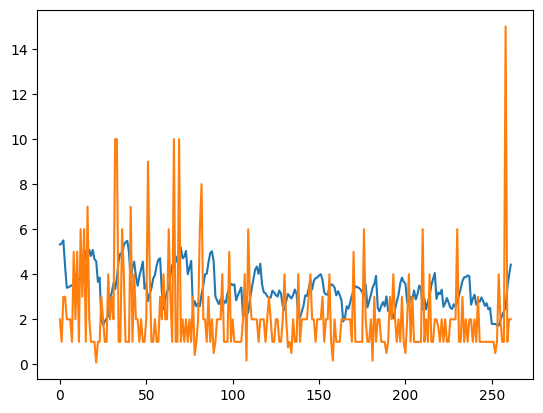

In [193]:
plt.plot(train_result['train'][:])
plt.plot(train_result['Actual'][:])

In [194]:
day = 60*60*24
year = 365.2425*day
df_model_rnn = df_model.copy()
df_model_rnn.index = pd.to_datetime(df_model_rnn.index) + pd.Timedelta(hours=23)
df_model_rnn['seconds'] = df_model_rnn.index.map(pd.Timestamp.timestamp)
df_model_rnn['year_sin'] = np.sin(df_model_rnn['seconds']*(2*np.pi/year))
df_model_rnn['year_cos'] = np.cos(df_model_rnn['seconds']*(2*np.pi/year))

In [195]:
df_model_rnn = df_model_rnn.drop('seconds', axis=1)
df_model_rnn.head()

,sold_quantity,year_sin,year_cos
date,,,
2020-01-04 23:00:00,1.0,0.065896,0.997826
2020-01-08 23:00:00,10.0,0.134348,0.990934
2020-01-21 23:00:00,5.0,0.350768,0.936462
2020-01-24 23:00:00,6.0,0.398609,0.917121
2020-02-11 23:00:00,1.0,0.659121,0.752037


In [196]:
def window_slide_method_2(df, windows_size = 7):
    
    df_np = df.to_numpy()
    X = []
    yhat = []
    for i in range(len(df_np)-windows_size):
        row = [r for r in df_np[i:i+windows_size]]
        X.append(row)
        label = df_np[i+windows_size][0]
        yhat.append(label)
    return np.array(X), np.array(yhat)

X_1, y_1 = window_slide_method_2(df_model_rnn)
X_1.shape, y_1.shape

((1262, 7, 3), (1262,))

In [197]:
X_train_1, y_train_1 = X_1[:850], y_1[:850]
X_val_1, y_val_1 = X_1[850:1000], y_1[850:1000]
X_test_1, y_test_1 = X_1[1000:], y_1[1000:]

In [198]:
# Define the model
model_rnn = Sequential()
model_rnn.add(InputLayer((7, 3)))  # Input shape (7, 1) for 7 timesteps with 1 feature
model_rnn.add(LSTM(128, activation='tanh'))  # SimpleRNN layer with 64 units
model_rnn.add(Dense(8, activation='relu'))  # Dense layer with ReLU activation
model_rnn.add(Dense(1, activation='linear'))  # Output layer with linear activation
# Display model summary
model_rnn.summary()
checkpoint = ModelCheckpoint('model_rnn/model_best.keras', save_best_only=True)
model_rnn.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0003), metrics=[RootMeanSquaredError()])
model_rnn.fit(X_train_1, y_train_1, validation_data=(X_val_1, y_val_1), epochs=10, callbacks=[checkpoint])
model_rnn = load_model('model_rnn/model_best.keras')

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 128)            │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,625 (268.07 KB)

 Trainable params: 68,625 (268.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 74.3867 - root_mean_squared_error: 8.5714 - val_loss: 153.4487 - val_root_mean_squared_error: 12.7440
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 75.6238 - root_mean_squared_error: 8.6448 - val_loss: 143.4449 - val_root_mean_squared_error: 12.3225
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61.5375 - root_mean_squared_error: 7.6906 - val_loss: 142.3688 - val_root_mean_squared_error: 12.2739
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64.5072 - root_mean_squared_error: 7.8821 - val_loss: 141.7559 - val_root_mean_squared_error: 12.2475
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.3809 - root_mean_squared_error: 7.6231 - val_loss: 141.4610 - val_root_mean_squared_error: 12.2356
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 63.5921 - root_mean_squared_error: 7.6880 - val_loss: 140.4996 - val_root_mean_squared_error: 12.1914
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0

In [199]:
train_prediction_1 = model_rnn.predict(X_test_1).flatten()
y_test_flat_1 = np.ravel(y_test_1)
train_result_1 = pd.DataFrame(data={'train': train_prediction_1, 'Actual': y_test_flat_1})
train_result_1

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


,train,Actual
0,4.535574,2.0
1,4.202455,1.0
2,3.792122,3.0
3,3.449338,3.0
4,3.288522,2.0
...,...,...
257,2.504479,1.0
258,2.510028,15.0
259,4.334759,1.0
260,4.269895,2.0


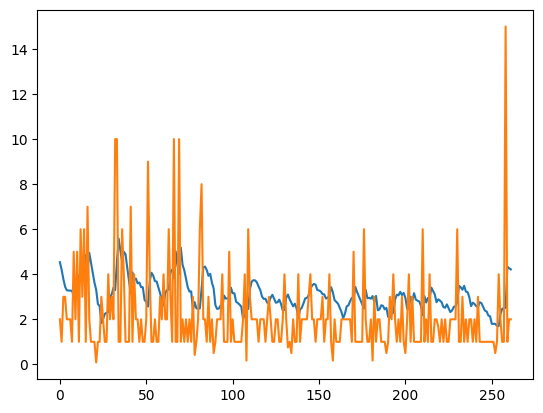

In [200]:
plt.plot(train_result_1['train'][:])
plt.plot(train_result['Actual'][:])

In [201]:
G = nx.Graph()
drop = ['unit_cost','unit_price']
df_model_2 = df.drop(columns=drop)
df_model_2

,sold_quantity,client_ID
date,,
2020-01-04,1.0,1141
2020-01-08,10.0,188
2020-01-21,5.0,188
2020-01-24,6.0,1664
2020-02-11,1.0,1433
...,...,...
2024-01-05,1.0,670
2024-01-05,15.0,375
2024-01-10,1.0,670


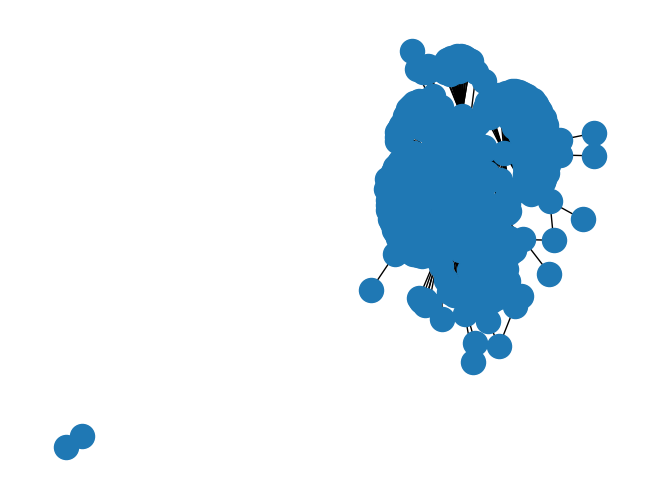

In [202]:
for index, row in df_model_2.iterrows():
    client_id = row['client_ID']
    qty_buy = row['sold_quantity']
    purchase_date = index

    if not G.has_node(client_id):
        G.add_node(client_id, type='client')

    if not G.has_node(qty_buy):
        G.add_node(qty_buy, type='item')

    G.add_edge(client_id, qty_buy, purchase_date=purchase_date)
    
nx.draw(G)